In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

# Regression with means and variances

Here we fit a regression model that gives us a predictive distribution. Given the data pairs, $(x,y)$. Consider a model where 

$$ y =  f(x) + n(x).$$

We want to learn a function $f(x)$. However our observed data, $y$, contains noise. $n(x)$ is the noise term. It's a mean zero Gaussion whos variance is a function of $x$. Note that the noise is not constant, but instead depends on $x$. This is a bit more general than the typical setup in e.g. linear regression where we assume this term is independent of $x$. 

The likelihood is

$$p(y|x) = \frac{1}{\sqrt{2\pi \sigma^2(x)}}\exp{\frac{-(y-f(x))^2}{2\sigma^2(x)}}$$

From this, we get the negative log-likelihood:

$$ L = \frac{(y-f(x))^2}{\sigma^2(x)}+\log(\sigma^2(x))$$


In this example, we will use MLPs to mobdel both $f(x)$ and $\sigma^2(x)$.

\* This follows the paper *Estimating the Mean and Variance of the Target Probability Distribution* by Nix and Weigend


## Synthetic Data

In [2]:
w_c = 5
w_m = 4

t = np.arange(0,np.pi/2, 0.01)
m = np.sin(w_m*t)
f = m* np.sin(w_c*t)

var_x = lambda x: 0.02 + 0.1*(1-np.sin(w_m*x))**2

var = np.array([var_x(tt) for tt in t])

In [3]:
D = []
X = []
for _ in range(3000):
    
    _x = np.random.uniform(low = 0, high = np.pi/2)
    _f = np.sin(w_m*_x)*np.sin(w_c*_x)
    
    _v = var_x(_x)
    _n = np.random.normal(scale = np.sqrt(_v))
    
    _d = _f + _n
    
    X.append(_x)
    D.append(_d)
    
X = np.array(X)
D = np.array(D)

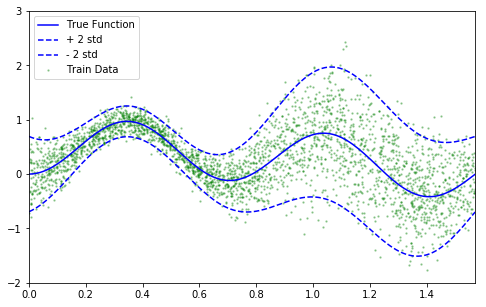

In [4]:
plt.figure(figsize = (8, 5))
plt.plot(t,f, '-', c = 'b', label = 'True Function');

plt.plot(t,f+2*np.sqrt(var), '--', c = 'b', label = '+ 2 std');
plt.plot(t,f-2*np.sqrt(var), '--', c = 'b', label = '- 2 std');

plt.scatter(X, D, c = 'g', label = 'Train Data', s = 2, alpha = 0.3)

plt.legend()
plt.xlim([0,np.pi/2])
plt.ylim([-2, 3]);

# Model

In [5]:
from Util.util import Model

In [6]:
class DistributionModel(Model):
    
    def __init__(self, mean_dims, var_dims, input_dim, out_dim):
        
        self.mean_dims = mean_dims
        self.var_dims = var_dims
        self.out_dim = out_dim
        
        self.x = tf.placeholder(name = 'input',
                                shape = (None, input_dim),
                                dtype = tf.float32)
        
        self.ground_truth = tf.placeholder(name = 'ground_truth',
                                           shape = (None, self.out_dim),
                                           dtype = tf.float32)   
        
        super().__init__()

                
    def build_forward(self):
        '''Build forward pass'''
        
        
        #MLP for mean
        for i, dim in enumerate(self.mean_dims):
            
            if i == 0:
                y_mu = tf.layers.Dense(units = dim, activation=tf.nn.tanh)(self.x)
            else:
                y_mu = tf.layers.Dense(units = dim, activation=tf.nn.tanh)(y_mu)

        self.mu = tf.layers.Dense(self.out_dim, activation=None)(y_mu)
        
        #MLP for variance
        for i, dim in enumerate(self.var_dims):
            
            if i == 0:
                y_var = tf.layers.Dense(units = dim, activation=tf.nn.tanh)(self.x)
            else:
                y_var = tf.layers.Dense(units = dim, activation=tf.nn.tanh)(y_var)

        
        self.var = tf.layers.Dense(self.out_dim, activation=tf.math.exp)(y_var)

    def build_train(self):
        
        # NLL
        self.loss = tf.reduce_mean((tf.pow((self.ground_truth - self.mu), 2)/self.var) + tf.log(self.var))
        
        # minimize loss with Adam
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
        
    def build_aux(self):
        
        # predicted class (arg max)
        self.pred = self.mu
        
    def predict_var(self,X, batch = 128):
        
        y_pred = []
        
        i = 0
        while i+batch <= len(X):
            xx = X[i:i+batch]
            _y  = self.sess.run(self.var, feed_dict = {self.x: xx})
            y_pred.extend(_y)
            
            i+=batch

        xx = X[i:]
        _y  = self.sess.run(self.var, feed_dict = {self.x: xx})
        y_pred.extend(_y)
            
        return np.array(y_pred)
        
    
    

In [7]:
tf.reset_default_graph()

In [8]:
m = DistributionModel(mean_dims=[64,64, 32], var_dims=[64,64,32], input_dim=1, out_dim=1)
loss_val = m.train(X_train = X[:,None], y_train=D[:, None], 
                   num_epoch=500, batch_size=500, verbose = False)

Initializing Model


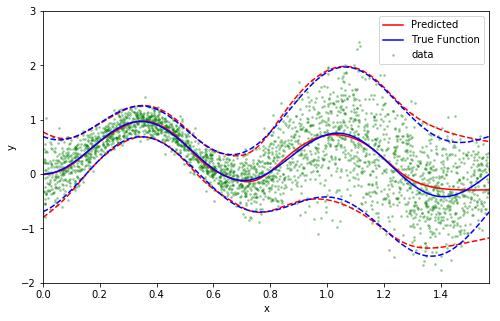

In [9]:
plt.figure(figsize = (8, 5))


y_pred = m.predict(t[:,None])
var_pred = m.predict_var(t[:,None])

plt.plot(t, np.squeeze(y_pred), c = 'r', label = 'Predicted')
plt.plot(t, np.squeeze(y_pred)-2*np.sqrt(np.squeeze(var_pred)), '--', c = 'r')
plt.plot(t, np.squeeze(y_pred)+2*np.sqrt(np.squeeze(var_pred)), '--', c = 'r')

plt.plot(t,f, '-', c = 'b', label = 'True Function');
plt.plot(t,f+2*np.sqrt(var), '--', c = 'b');
plt.plot(t,f-2*np.sqrt(var), '--', c = 'b');

plt.scatter(X, D, alpha = 0.3, c = 'g', s = 3, label = 'data')

plt.legend()
plt.xlim([0,np.pi/2])
plt.ylim([-2, 3])
plt.xlabel('x')
plt.ylabel('y');